<a href="https://colab.research.google.com/github/dmao1020/bigqhack_QAI_2022/blob/main/QAOA_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
#pip install pulser

In [96]:
#pip install igraph

In [425]:
import numpy as np
import igraph
from itertools import combinations

import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, Register
from pulser_simulation import Simulation
from pulser.devices import Chadoq2

from scipy.optimize import minimize

In [426]:
def pos_to_graph(pos):
    rb = Chadoq2.rydberg_blockade_radius(1.0)
    g = igraph.Graph()
    N = len(pos)
    edges = [
        [m, n]
        for m, n in combinations(range(N), r=2)
        if np.linalg.norm(pos[m] - pos[n]) < rb
    ]
    g.add_vertices(N)
    g.add_edges(edges)
    return g

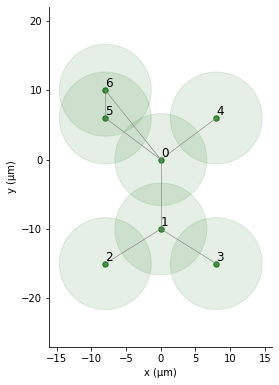

In [427]:

pos =np.array([[0.0, 0.0], 
               [0.0, -10.0],
               [-8, -15], 
               [8, -15], 
               [8, 6], 
               [-8, 6], 
               [-8, 10]])
#([[0,1],[0,2],[0,3],[1,4],[1,5]])
#
#pos = np.array([[0.0, 0.0], [-4, -7], [4, -7], [8, 6], [-8, 6]])

G = pos_to_graph(pos)
qubits = dict(enumerate(pos))

reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

In [428]:
LAYERS = 3

# Parametrized sequence
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)

if LAYERS == 1:
    t_list = [t_list]
    s_list = [s_list]

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 1.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

In [429]:
def quantum_loop(parameters):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    simul = Simulation(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

In [430]:
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}

In [431]:
example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])



In [432]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["101100", "010011"]  # MIS indexes
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

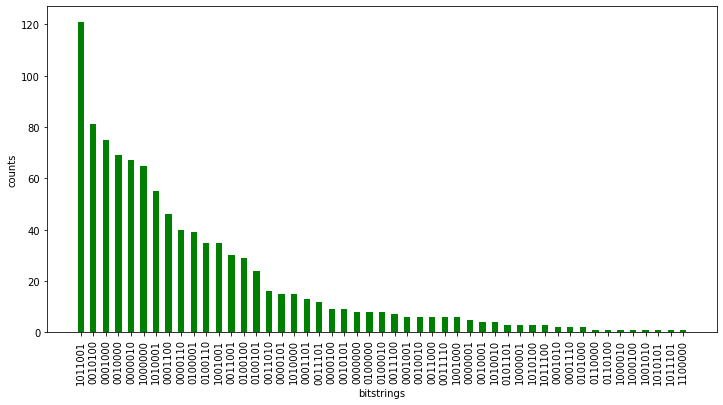

In [433]:
plot_distribution(example_dict)


In [434]:
def get_cost_colouring(bitstring, G, penalty=10):
    z = np.array(list(bitstring), dtype=int)
    A = np.array(G.get_adjacency().data)
    # Add penalty and bias:
    cost = penalty * (z.T @ np.triu(A) @ z) - np.sum(z)
    return cost


def get_cost(counter, G):
    cost = sum(counter[key] * get_cost_colouring(key, G) for key in counter)
    return cost / sum(counter.values())

In [435]:
get_cost(example_dict, G)

0.174

In [436]:
def func(param, *args):
    G = args[0]
    C = quantum_loop(param)
    cost = get_cost(C, G)
    return cost

In [ ]:
res = minimize(
    func,
    args=G,
    x0=np.r_[guess["t"], guess["s"]],
    method="Nelder-Mead",
    tol=1e-5,
    options={"maxiter": 200},
)

In [ ]:
count_dict = quantum_loop(res.x)
plot_distribution(count_dict)

In [ ]:
import operator

print ("count_dict:",count_dict)
sorted_x = sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True)


In [ ]:
def convert_opt(opt_str):
  row = [int(num_i) for num_i in opt_str]
  return row
"""
_opt_1 = sorted_x[2][0]
opt_1= convert_opt(_opt_1)
print (opt_1)

A = np.array(G.get_adjacency().data)
print (A)
ans = np.where((A == opt_1).all(axis=1))
print (ans)

_opt_1 = sorted_x[2][0]
opt_1= convert_opt(_opt_1)
print (opt_1)

A = np.array(G.get_adjacency().data)
print (A)
ans = np.where((A == opt_1).all(axis=1))
print (ans)
"""
_idx = []
A = np.array(G.get_adjacency().data)
print (A)
for key in count_dict:
  #print (key)
  opt_1= convert_opt(key)
  #print (opt_1)

  ans = np.where((A == opt_1).all(axis=1))[0]
  if len(ans)==1:
    #print (ans)
    _idx.append(ans[0])

_ans_arr = np.zeros(np.shape(A)[0])
_ans_arr[_idx] = 1
print ("The optimum DCS is:",_ans_arr)